In [1]:
import time
import torch
from torcheval.metrics import MulticlassAccuracy
import warnings
import seaborn as sns
import matplotlib.pyplot  as plt
from IPython import display
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [2]:
def sequence_generator(size = None):
    if not size:
        size = 128
    x = torch.randint(0, 9, (size,))
    y = torch.zeros_like(x)
    y[0] = x[0]
    y[1:] = (x[1:]+x[0]) % 10
    yield torch.stack((x,y))

In [3]:
class Network(torch.nn.Module):
    def __init__(self, RNNClass, input_size):
        super(Network, self).__init__()
        hidden_size = 256
        self.rnn = RNNClass(input_size, hidden_size, batch_first=True)        
        self.fc1 = torch.nn.Linear(hidden_size, 512)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.33)
        self.out = torch.nn.Linear(512, 10)
            
    def forward(self, x, state=None):
        
        x, _ = self.rnn(x)
        x = self.relu(self.dropout(self.fc1(x))) #Дропаут здесь вряд ли нужен, забыл отключить
        x = self.out(x)
        return x

In [4]:
def test_output(model):
    with torch.no_grad():
        batch = torch.stack([next(sequence_generator(64)) for _ in range(100)])
        input = torch.nn.functional.one_hot(batch[:,1,:], 10).to(device) 
        output = model(input.float())
        print(output.shape)

In [5]:
rnn_model = Network(torch.nn.RNN, 10).to(device)
gru_model = Network(torch.nn.GRU, 10).to(device)
lstm_model = Network(torch.nn.LSTM, 10).to(device)

test_output(rnn_model)
test_output(gru_model)
test_output(lstm_model)

torch.Size([100, 64, 10])
torch.Size([100, 64, 10])
torch.Size([100, 64, 10])


In [6]:
def train(batch_size, sequence_len, n_iter, model):

    train_accuracy = MulticlassAccuracy(num_classes=10).to(device)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                lr=0.0001, 
                                # weight_decay=0.00001
                                )

    warnings.filterwarnings('ignore')

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))
    axes[0].set_title('Batch Loss')
    axes[1].set_title('Batch Accuracy')
    axes[0].grid()
    axes[1].grid()

    BATCH_SIZE = batch_size
    SEQUENCE_LENGTH = sequence_len
    N_ITER = n_iter
    model = model

    epoch_counter = 0
    train_losses = []
    train_accs = []

    model.to(device)

    while epoch_counter <= N_ITER:
        batch = torch.stack([next(sequence_generator(SEQUENCE_LENGTH)) for _ in range(BATCH_SIZE)])
        start = time.time()
        train_loss = 0.

        input = torch.nn.functional.one_hot(batch[:,0,:], 10).to(device)
        output = model(input.float())  
        y_true = batch[:,1,:].to(device)
        model.train()
        optimizer.zero_grad()

        tr_loss = criterion(output.view(-1, 10), y_true.flatten())
        predictions = torch.argmax(output, dim=2)
        train_accuracy.update(predictions.flatten(), y_true.flatten())
        tr_loss.backward()
        optimizer.step()
        train_loss += tr_loss.item()
        epoch_train_loss = train_loss
        train_losses.append(epoch_train_loss)
        epoch_train_acc = train_accuracy.compute()
        train_accs.append(epoch_train_acc.item())
        epoch_counter += 1

        if epoch_counter % 10 == 0:
            sns.lineplot(train_losses, c='red', ax = axes[0])
            sns.lineplot(train_accs, c='green', ax = axes[1])
            display.display(fig, clear=True)
            plt.close()

            print(f'Epoch {epoch_counter} -- Batch Loss: {epoch_train_loss:.4f} -- Batch Accuracy: {epoch_train_acc:.4f} -- Time: {time.time() - start:.2f}s')

In [7]:
def predict(model):
    model = model
    batch = torch.stack([next(sequence_generator(64)) for _ in range(1)])
    x = batch[:,0,:]
    y = batch[:,1,:]
    nl = '\n'
    with torch.no_grad():
        input = torch.nn.functional.one_hot(x, 10).to(device) 
        output = model(input.float())
        y_pred = torch.argmax(output, dim=2)
        print(f'x:{nl}{x}{nl}y:{nl}{y}{nl}Predicted y:{nl}{y_pred}')

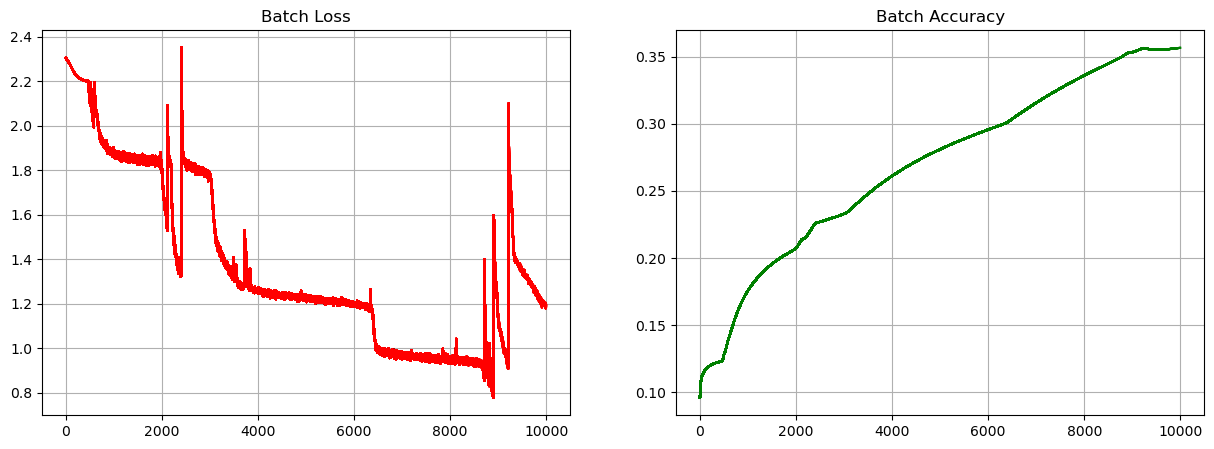

Epoch 10000 -- Batch Loss: 1.1912 -- Batch Accuracy: 0.3567 -- Time: 3.23s


In [41]:
train(5000, 64, 10000, rnn_model)

In [47]:
predict(rnn_model)

x:
tensor([[5, 4, 5, 0, 8, 7, 3, 0, 2, 8, 6, 8, 6, 8, 8, 6, 6, 8, 8, 2, 2, 0, 4, 6,
         5, 2, 7, 4, 3, 2, 0, 0, 4, 1, 7, 3, 4, 0, 8, 4, 8, 4, 3, 3, 2, 8, 6, 4,
         6, 2, 5, 1, 2, 2, 6, 3, 1, 3, 8, 0, 2, 7, 4, 4]])
y:
tensor([[5, 9, 0, 5, 3, 2, 8, 5, 7, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 7, 7, 5, 9, 1,
         0, 7, 2, 9, 8, 7, 5, 5, 9, 6, 2, 8, 9, 5, 3, 9, 3, 9, 8, 8, 7, 3, 1, 9,
         1, 7, 0, 6, 7, 7, 1, 8, 6, 8, 3, 5, 7, 2, 9, 9]])
Predicted y:
tensor([[5, 9, 0, 5, 3, 1, 7, 4, 2, 1, 1, 1, 9, 3, 1, 1, 2, 4, 2, 5, 7, 5, 7, 9,
         0, 7, 0, 7, 6, 2, 4, 4, 9, 1, 1, 8, 9, 3, 8, 0, 3, 0, 8, 6, 8, 2, 9, 0,
         1, 5, 0, 7, 7, 8, 2, 6, 7, 8, 1, 3, 5, 3, 7, 4]], device='cuda:0')


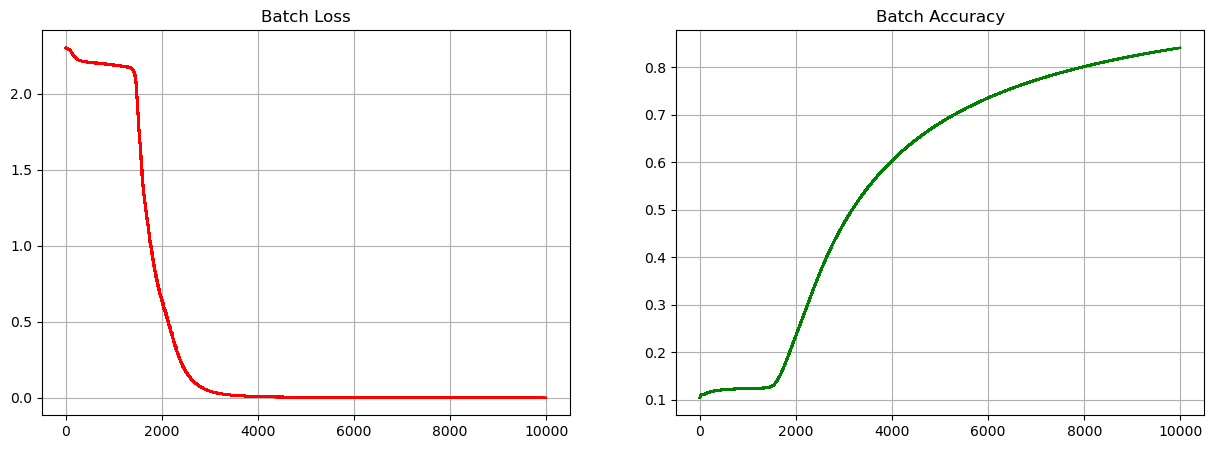

Epoch 10000 -- Batch Loss: 0.0001 -- Batch Accuracy: 0.8416 -- Time: 1.91s


In [8]:
train(5000, 64, 10000, gru_model)

In [14]:
predict(gru_model)

x:
tensor([[6, 0, 0, 3, 6, 2, 2, 2, 3, 7, 2, 5, 3, 0, 8, 0, 5, 0, 7, 2, 6, 7, 4, 1,
         3, 5, 1, 8, 8, 6, 5, 4, 5, 8, 4, 5, 2, 2, 4, 0, 7, 5, 3, 5, 0, 6, 2, 1,
         2, 2, 1, 7, 2, 4, 1, 6, 1, 8, 8, 3, 8, 5, 0, 6]])
y:
tensor([[6, 6, 6, 9, 2, 8, 8, 8, 9, 3, 8, 1, 9, 6, 4, 6, 1, 6, 3, 8, 2, 3, 0, 7,
         9, 1, 7, 4, 4, 2, 1, 0, 1, 4, 0, 1, 8, 8, 0, 6, 3, 1, 9, 1, 6, 2, 8, 7,
         8, 8, 7, 3, 8, 0, 7, 2, 7, 4, 4, 9, 4, 1, 6, 2]])
Predicted y:
tensor([[6, 6, 6, 9, 2, 8, 8, 8, 9, 3, 8, 1, 9, 6, 4, 6, 1, 6, 3, 8, 2, 3, 0, 7,
         9, 1, 7, 4, 4, 2, 1, 0, 1, 4, 0, 1, 8, 8, 0, 6, 3, 1, 9, 1, 6, 2, 8, 7,
         8, 8, 7, 3, 8, 0, 7, 2, 7, 4, 4, 9, 4, 1, 6, 2]], device='cuda:0')


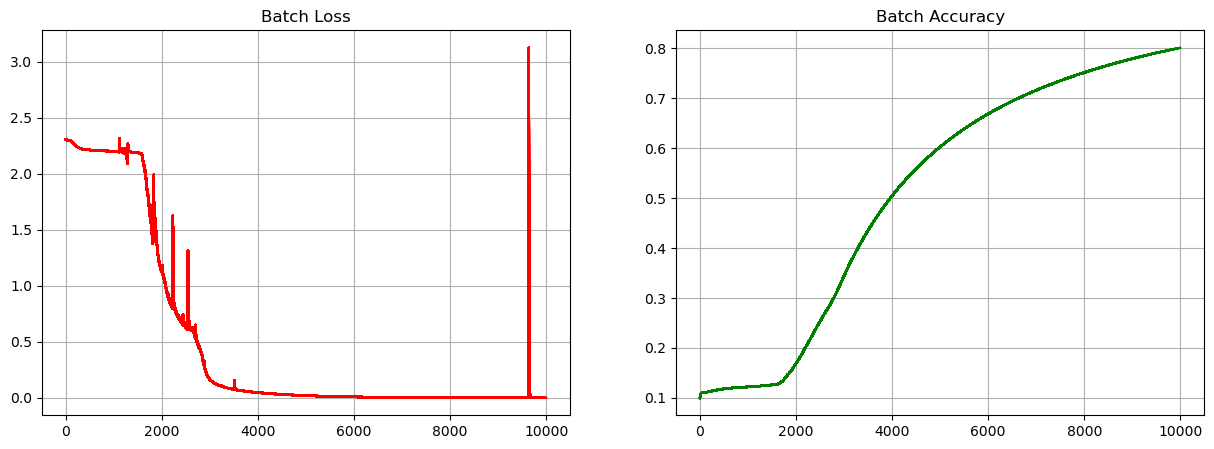

Epoch 10000 -- Batch Loss: 0.0012 -- Batch Accuracy: 0.8008 -- Time: 2.03s


In [8]:
train(5000, 64, 10000, lstm_model)

In [19]:
predict(lstm_model)

x:
tensor([[5, 1, 6, 7, 5, 1, 4, 8, 8, 1, 1, 0, 5, 5, 6, 2, 1, 7, 0, 4, 7, 0, 0, 8,
         8, 5, 4, 4, 8, 1, 0, 4, 1, 5, 7, 4, 8, 7, 3, 7, 0, 2, 4, 5, 4, 7, 5, 8,
         1, 7, 8, 8, 4, 2, 4, 4, 5, 1, 1, 2, 4, 5, 6, 6]])
y:
tensor([[5, 6, 1, 2, 0, 6, 9, 3, 3, 6, 6, 5, 0, 0, 1, 7, 6, 2, 5, 9, 2, 5, 5, 3,
         3, 0, 9, 9, 3, 6, 5, 9, 6, 0, 2, 9, 3, 2, 8, 2, 5, 7, 9, 0, 9, 2, 0, 3,
         6, 2, 3, 3, 9, 7, 9, 9, 0, 6, 6, 7, 9, 0, 1, 1]])
Predicted y:
tensor([[5, 6, 1, 2, 0, 6, 9, 3, 3, 6, 6, 5, 0, 0, 1, 7, 6, 2, 5, 9, 2, 5, 5, 3,
         3, 0, 9, 9, 3, 6, 5, 9, 6, 0, 2, 9, 3, 2, 8, 2, 5, 7, 9, 0, 9, 2, 0, 3,
         6, 2, 3, 3, 9, 7, 9, 9, 0, 6, 6, 7, 9, 0, 1, 1]], device='cuda:0')
